In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [21]:
train = pd.read_csv("datasets/digit_recognition/train.csv")
test = pd.read_csv("datasets/digit_recognition/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

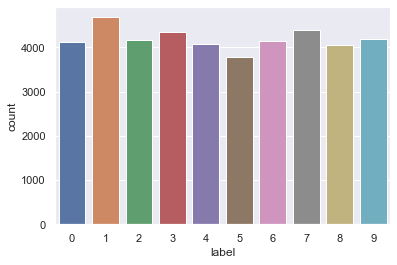

In [22]:
sns.set()

Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(x=Y_train)

Y_train.value_counts()

In [23]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [24]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [25]:
# Normalize the data
'''
We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the CNN converg faster on [0..1] data than on [0..255].
'''
X_train = X_train / 255.0
test = test / 255.0

In [26]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

(42000, 28, 28, 1)


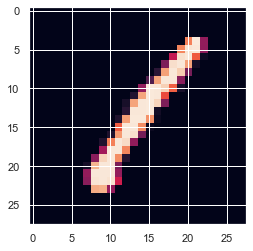

In [27]:
print(X_train.shape)
plt.imshow(X_train[0])

In [28]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [29]:
random_seed = 2

In [30]:
'''
I choosed to split the train set in two parts : a small fraction (10%)
became the validation set which the model is evaluated and the rest (90%) 
is used to train the model.
'''
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

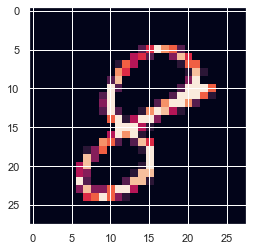

In [31]:
g = plt.imshow(X_train[0][:,:,0])

In [32]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [33]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [34]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [36]:
epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [38]:
'''
An epoch is a term used in machine learning and indicates the number of
passes of the entire training dataset the machine learning algorithm has completed. 
Datasets are usually grouped into batches (especially when the amount of data is very large).
'''
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/5
439/439 - 19s - loss: 0.4257 - accuracy: 0.8625 - val_loss: 0.0538 - val_accuracy: 0.9831
Epoch 2/5
439/439 - 17s - loss: 0.1360 - accuracy: 0.9585 - val_loss: 0.0419 - val_accuracy: 0.9883
Epoch 3/5
439/439 - 18s - loss: 0.0986 - accuracy: 0.9715 - val_loss: 0.0311 - val_accuracy: 0.9907
Epoch 4/5
439/439 - 18s - loss: 0.0839 - accuracy: 0.9754 - val_loss: 0.0345 - val_accuracy: 0.9893
Epoch 5/5
439/439 - 18s - loss: 0.0752 - accuracy: 0.9774 - val_loss: 0.0333 - val_accuracy: 0.9905


C:\Users\E2\AppData\Local\Temp\ipykernel_15720\2462039241.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


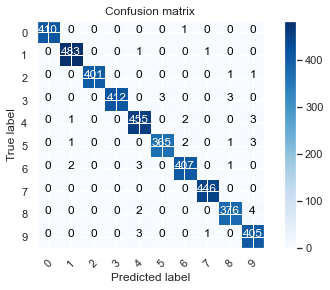

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [40]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [41]:
print(results)

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64


2


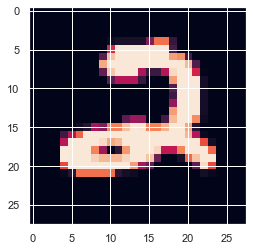

0


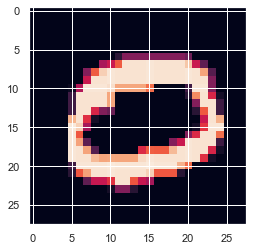

In [42]:
# Predictin only 2 element
for i in range(2):
    res = model.predict(np.array([test[i],]))
    print(np.argmax(res))
    plt.imshow(test[i])
    plt.show()

In [56]:
from PIL import Image
import cv2
img = Image.open('datasets/test_digits_png/test_digit.png').convert("L")
img = np.invert(img)
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(-1,28,28,1)

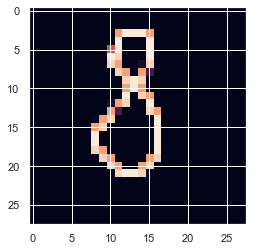

In [57]:
plt.imshow(img)
plt.show()

In [58]:
res = model.predict(im2arr)
print(np.argmax(res))

8
